## 1. 数据处理和分析

### 1.1 数据预处理

读取从 [UN Comtrade Database](https://comtrade.un.org/data/) 获取的 2016-2020 年全球铜及其精炼物（2603）贸易记录，并处理：

1. 去除贸易对象为 World 的数据行
2. 并保留关心的数据列：报告者及其代码、贸易对象及代码、贸易类型、贸易额

**！注**：数据中上报者（Reporter）可能包含国家和地区以及**中国**港澳台地区，为方便起见以下统称“国家”.

In [ ]:
from src.main import Report, pd, show_cluster_list, plt

In [2]:
report_16 = Report('src/data/format-2016-world-copper-2063-trade.json', '2016')
report_17 = Report('src/data/format-2017-world-copper-2063-trade.json', '2017')
report_18 = Report('src/data/format-2018-world-copper-2063-trade.json', '2018')
report_19 = Report('src/data/2019-world-copper-2063-trade.csv', '2019')
report_20 = Report('src/data/format-2020-world-copper-2063-trade.json', '2020')

In [3]:
reports = [report_16, report_17, report_18, report_19, report_20]

report_16.data.getByCode(97)

,Code,name
345,97,EU-28


### 1.2 数据分析与检验*

以 2019 年数据为例，进行数据分析与检验

1. 获取贸易参与者

In [4]:
report_19.check_data()

上报进贸易记录的国家总数（不含重复）:  89
上报进贸易记录的中的贸易对象国家总数（不含重复）:  109
上报进贸易记录的国家，和记录中的贸易对象国家总数（不含重复）:  119


2. 数据检验

从上面数据可以看出，各国上报的记录显然是有出入的，即上报记录中涉及的国家数要比上报数据的国家数多，这至少说明了一些参与了贸易的国家没有上报贸易记录

下面以中国上报的记录为例检查和说明：

        1. 查看中国上报的进口记录

In [5]:
report_19.view_logs_by_china()

中国上报的进口记录中，涉及出口国家的个数:  56


,Reporter Code,Reporter,Partner Code,Partner,Trade Flow,Trade Value (US$)
247,156,China,8,Albania,Import,17013004
248,156,China,36,Australia,Import,1666113958
250,156,China,51,Armenia,Import,510563982
251,156,China,68,Bolivia (Plurinational State of),Import,2677980
252,156,China,76,Brazil,Import,557705819
255,156,China,100,Bulgaria,Import,50
256,156,China,104,Myanmar,Import,2850825
258,156,China,124,Canada,Import,910149220
260,156,China,152,Chile,Import,12076025483
261,156,China,170,Colombia,Import,56382455


        2. 查看中国进口对象上报的对中国的出口记录

In [6]:
report_19.view_logs_about_china()

全球上报了对中国有出口记录的国家 43


,Reporter Code,Reporter,Partner Code,Partner,Trade Flow,Trade Value (US$)
13,36,Australia,156,China,Export,1585564428
36,51,Armenia,156,China,Export,174415305
68,68,Bolivia (Plurinational State of),156,China,Export,3882938
88,76,Brazil,156,China,Export,442971407
116,100,Bulgaria,156,China,Export,71216190
161,124,Canada,156,China,Export,764979617
208,152,Chile,156,China,Export,9649325301
316,170,Colombia,156,China,Export,40352028
328,204,Benin,156,China,Export,1708
334,218,Ecuador,156,China,Export,3562481


对比上面两个表格，显然各国出入口数据是**普遍**有出入的：

首先，进出口对象数量上就不一致：中国上报记录中显示，中国 2019 年共从 56 个国家进口铜资源；而只有 43 个国家上报了对中国出口铜资源的记录

其次，对于有些进出口双方都上报了记录的情况，双方上报的贸易金额不一致，有的甚至出入较大

这可能是有以下的原因导致的：

1. 由于政策和统计方法不同导致的上报数据的结果不同. 
2. 由于货物在进出口过程中经第三方国家中转，而进出口国家对于出入口的目标国家登记不一致导致.
3. 其他可能原因.

## 2. 构建网络

根据以上数据和分析，构建有向加权网络是合适的，具体如下：

1. 以国家为节点，进出口关系为指向（出口国 -> 进口国），贸易金额为权重，构建有向加权图

2. 对于进出口关系，忽略各个国家之间上报数据的差异，即只要在任何一条记录中出现进出口关系即双方存在贸易关系，则为对应节点添加连边

3. 对于贸易金额，若两方上报金额不一致则取两者均值
  

绘制网络（以 2020 年为例）：

In [7]:
#report_20.net.draw()

## 3. 基于连接信息熵的节点重要性

### 3.1 定义

#### 3.1.1 连接度 $A_i$
定义有向加权网络中节点的连接度为
$$
A_i = \theta\sum_{j\in \Gamma_{i\_in}}k_j + (1-\theta)\sum_{j\in \Gamma_{i\_out}}k_j
$$

其中 $\Gamma_{i\_in}$ 是指向节点 $i$ 的邻居节点集，$\Gamma_{i\_out}$ 是由节点 $i$ 指向的邻居节点集；$k_j$ 是对应节点的度；$\theta \in [0,1]$ 是参数.

具体地，有向加权网络中，定义节点 $k_j$ 的度为：

$$
\begin{aligned}
k_j &= \lambda k_i^{in} + (1-\lambda)k_i^{out} \\
    &= \lambda \sum_{i=1}^m w_{ij} + (1 - \lambda)\sum_{i=1}^m w_{ji}
\end{aligned}
$$

其中 $w_{uv}$ 表示由节点 $u$ 指向节点 $v$ 的边的权重，若该边不存在则记为 $0$；$\lambda$ 为出入边的权重参数.

具体地上式表示，在节点 $j$ 与其邻居节点的连边中，按权重求出入连边的加重和.

#### 3.1.2 连边概率 $P_{i_j}$

定义连边概率 $P_{i_j}$ 为节点 $i$ 被其邻居节点 $j$ 选择进行连边的概率：
$$
P_{i_j} = \frac{k_i}{A_j}, \ \ \ \ (j\in\Gamma_i)
$$

#### 3.1.3 连接信息熵 $E_i$

定义有向网络中连接信息熵如下：

$$
E_i = \sum\limits_{j\in\Gamma_j}\left| P_{i_j}\log_2 P_{i_j} \right|
$$

*这里取绝对值是因为 $\theta$ 加权的原因，$P_{i_j}$ 可能大于 $1$*

## 4. 实验和结果

### 4.1 求各节点的连接信息熵
根据第 3 节给出的定义，求各节点的连接信息熵，并将前 20 的连接信息熵绘图如下：

*实验中取 $\theta, \lambda = 0.7$.*

In [8]:
'''
for report in reports:
    print(report.name + '年连接信息熵分布')
    report.net.drawEntropiesBar()
'''

"\nfor report in reports:\n    print(report.name + '年连接信息熵分布')\n    report.net.drawEntropiesBar()\n"

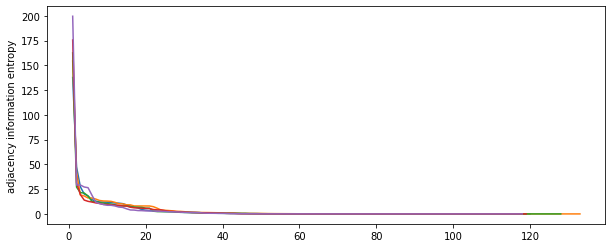

In [9]:
plt.figure(figsize=(10, 4))
report_16.draw_entropy_plot(120)
report_17.draw_entropy_plot()
report_18.draw_entropy_plot()
report_19.draw_entropy_plot()
report_20.draw_entropy_plot()
plt.show()

从上表可以看出，中国、欧盟等铜贸易大国位列前茅，且前二十名均为贸易和工业水平发达的国家，说明使用“连接信息熵”来衡量铜贸易网络节点的重要性具备一定的合理性.

### 4.2 层次聚类
对个节点的信息熵进行层次聚类，选择聚类数为 6；并为每个节点设置聚类标签，按熵值从大到小标记为 1 - 6

### 4.3 选取属性并进行离散化划分

选取以下属性，并选择聚类层数：

* IS：入强度, 6 层，反应进口贸易总额
* OS: 出强度，6 层，反应出口贸易总额
* DC: 度中心性，6 层，反应贸易伙伴的数量
* BC: 中介中心性，6 层，反应在贸易网络中的枢纽性质（不考虑权重）
* CC: 接近中心性，6 层，反应与其他贸易者之间的平均距离（不考虑权重）

属性值由大到小标记为 1-6

In [10]:
for report in reports:
    report.cluster_nodes()

In [11]:
cluster_list = show_cluster_list(reports)

In [12]:
cluster_list.head()

,code,code,code,code,code
label,,,,,
1,156,156,156,156,156
2,97,97,97,152,"97,124,975,724"
3,528,"410,724,100,152,784","410,975,152",724,276
4,"124,410","276,699,975,604,36","276,724,100,710,392,757,604","410,276,116,100,等12项","410,842,392,76,152,860"
5,"100,276,152,724,等13项","124,826,842,392,等10项","124,36,842,699,826,76,268,376,48","124,528,710,458,等13项","268,36,604"


In [13]:
writer = pd.ExcelWriter('cluster_list.xlsx')
cluster_list.to_excel(writer, float_format='%.5f')
writer.save()

In [14]:
report_19.show_nodes_attribute()

     code                name  IS  OS  DC  BC  CC  label
0     156               China   1   6   1   1   1      1
1     152               Chile   6   1   2   2   2      2
2     724               Spain   4   5   3   4   2      3
3     757         Switzerland   6   6   5   5   3      4
4     392               Japan   2   6   5   6   3      4
..    ...                 ...  ..  ..  ..  ..  ..    ...
114    40             Austria   6   6   6   6   4      6
115   642             Romania   6   6   5   5   4      6
116   643  Russian Federation   5   6   5   6   3      6
117   212            Dominica   6   6   6   6   6      6
118    50          Bangladesh   6   6   6   6   6      6

[119 rows x 8 columns]


上表以 2019 年数据，展示了各个节点的 5 个条件属性及 1 个决策属性所在的层次序号（1-6）

### 4.5 生成决策树

使用 ID3 算法生成决策树

In [15]:
for report in reports:
    report.decision_tree
    report.show_dt_accuracy()
    report.save_decision_tree('outputs/decision_tree_' + report.name + '.json')


决策树的正确率： 99.17355371900827 %
决策树的正确率： 94.73684210526315 %
决策树的正确率： 96.09375 %
决策树的正确率： 94.9579831932773 %
决策树的正确率： 98.30508474576271 %


决策树（2019）：

![decistion_tree](outputs/decision_tree.png)

根据决策树生成决策表：

In [16]:
for report in reports:
    report.decision_list

In [17]:
pd.DataFrame(report_19.decision_list)[report_19.attribute_names + ['label']].sort_values('label')

,IS,OS,DC,BC,CC,label
0,NaN,NaN,1,NaN,NaN,1
1,NaN,1.0,2,NaN,NaN,2
2,NaN,2.0,2,NaN,NaN,2
3,NaN,3.0,2,NaN,NaN,2
5,NaN,5.0,2,NaN,NaN,2
...,...,...,...,...,...,...
39,1.0,NaN,5,NaN,NaN,6
64,6.0,NaN,5,6.0,1.0,6
65,6.0,1.0,5,6.0,2.0,6
67,6.0,3.0,5,6.0,2.0,6


上表展示了决策树中的 86 条决策规则中各条件属性和决策属性的取值，NaN 表示该条件属性无需判断.

例如若某一结点 DC 属性值为 1，则无需判断其余属性即可得到该节点的决策属分区为 1 的决策结论. 事实上，仅有中国的 DC 为 1，且仅有中国决策属性为 1，所以继续判断其余属性时多余的.

### 4.6 层次风险模型

1. 条件属性的概率分布

$$
p_{jA_i} = \frac{\#jA_i}{N}
$$

其中 $A_i$ 表示条件属性，$jA_i$ 表示条件属性 $A_i$ 的属性取值. $\#jA_i$ 表示属性 $A_i$ 取 $j$ 时的样本数，$N$ 表示总样本数。


下面计算各个条件属性的概率分布：

In [18]:
for report in reports:
    report.set_attribute_probability()

2. 决策规则的概率分布

$$
    P_{\text{Rule}l} = p_{jA_i}\cdots p_{jA_p}
$$

其中，$p_{jA_k}$ 表示在决策规则 $l$ 中对应的各条件属性 $A_k$ 的取值为 $j$ 的概率.

*这里将各条件属性的分布近似看做为相互独立，即某条件属性的取值不受其他条件属性取值的影响*

下面计算各个决策规则的概率分布：

In [21]:
report_16.decision_list

[{'DC': 1, 'label': 1},
 {'DC': 2, 'label': 2},
 {'DC': 3, 'IS': 1, 'label': 5},
 {'DC': 3, 'IS': 2, 'label': 5},
 {'DC': 3, 'IS': 3, 'label': 5},
 {'DC': 3, 'IS': 4, 'label': 5},
 {'DC': 3, 'IS': 5, 'label': 4},
 {'DC': 3, 'IS': 6, 'label': 5},
 {'DC': 4, 'IS': 1, 'label': 5},
 {'DC': 4, 'IS': 2, 'label': 5},
 {'DC': 4, 'IS': 3, 'CC': 1, 'label': 4},
 {'DC': 4, 'IS': 3, 'CC': 2, 'label': 4},
 {'DC': 4, 'IS': 3, 'CC': 3, 'label': 5},
 {'DC': 4, 'IS': 3, 'CC': 4, 'label': 4},
 {'DC': 4, 'IS': 3, 'CC': 5, 'label': 4},
 {'DC': 4, 'IS': 3, 'CC': 6, 'label': 4},
 {'DC': 4, 'IS': 4, 'label': 5},
 {'DC': 4, 'IS': 5, 'label': 5},
 {'DC': 4, 'IS': 6, 'BC': 1, 'label': 5},
 {'DC': 4, 'IS': 6, 'BC': 2, 'label': 5},
 {'DC': 4, 'IS': 6, 'BC': 3, 'label': 5},
 {'DC': 4, 'IS': 6, 'BC': 4, 'CC': 1, 'label': 3},
 {'DC': 4, 'IS': 6, 'BC': 4, 'CC': 2, 'label': 3},
 {'DC': 4, 'IS': 6, 'BC': 4, 'CC': 3, 'label': 6},
 {'DC': 4, 'IS': 6, 'BC': 4, 'CC': 4, 'label': 3},
 {'DC': 4, 'IS': 6, 'BC': 4, 'CC': 5, 'l

下面绘制决策规则的概率分布柱状图：

In [25]:
for report in reports:
    print(report.name + '年决策路径概率分布')
    report.decision_probability_bar()

2016年决策路径概率分布
[[0.008264462809917356], [0.008264462809917356], [2.4986135284033322e-05, 0.0001249306764201666, 0.0007745701938050329, 7.495840585209997e-05, 0.0006496395173848664], [0.0024588484393142547, 2.201448327209732e-05, 0.0001100724163604866, 0.0006824489814350169, 6.604344981629197e-05, 0.0005723765650745303], [0.00020490403660952122, 0.00020490403660952122, 0.0006147121098285637, 0.00020490403660952122, 0.021105115770780686, 0.0008879174919745919, 0.0008879174919745919, 0.0012107965799653525, 0.0008879174919745919, 0.010655009903695103, 0.000755830592342008, 0.001511661184684016, 0.000755830592342008, 0.0001561633455252083, 0.0001561633455252083, 0.0003123266910504166, 0.0001561633455252083, 0.0007808167276260414, 0.06651309212609671, 0.020490403660952124], [0.0013742374406218326, 0.01733413135329812, 0.23140495867768596, 0.005122600915238031, 0.010245201830476062, 0.005122600915238031, 0.12806502288095076, 0.0037255279383549313, 0.018627639691774656, 0.20490403660952122, 0.1

TypeError: '<' not supported between instances of 'str' and 'int'

ValueError: 
\text{Path}_l
^
Unknown symbol: \text, found '\'  (at char 0), (line:1, col:1)

<Figure size 1440x1440 with 1 Axes>

以第一个图为例，使用柱状图的形式展示了 86 条决策规则的概率值，并且按照决策规则的最终决策属性的取值进行了分区. 例如，决策结果为 1 的决策规则只有 1 条，其概率约为 $0.008403$，即图中从左数第一根柱形图.

3. 节点脆弱性风险

节点脆弱性在对应离散分区下的层次风险：

$$
  P_j = \sum_{l=1}^MP_{\text{Rule}l}(j_{A_n})
$$

$P_j$ 表示了对于任意节点，通过决策树，做出决策属性为 $j$ 的概率，即各个决策属性为 $j$ 的决策规则的概率求和.
  

In [23]:
for report in reports:
    report.get_hierarchical_risk()
    print(report.name + '年层次风险分布')
    report.hierarchical_risk_bar()

KeyError: 'p'

上图展示了各个决策属性的概率分布，其中决策属性为 $1,2,3$ 的概率值较小，决策属性为 $4,5,6$ 的概率较大，决策属性为 $6$ 的概率尤其大.

In [ ]:
import numpy as np

xs = np.arange(10) + 1 + 2
xs = [[1,2],[2,3]]

In [ ]:
[x for j in xs for x in j]

[1, 2, 2, 3]

In [ ]:
[x for j in xs for x in j]

[1, 2, 2, 3]

In [ ]:
res = []
for j in xs:
    for x in j:
        res.append(x)

res

[1, 2, 2, 3]

In [26]:
ps = [[0.008264462809917356], [0.008264462809917356], [2.4986135284033322e-05, 0.0001249306764201666, 0.0007745701938050329, 7.495840585209997e-05, 0.0006496395173848664], [0.0024588484393142547, 2.201448327209732e-05, 0.0001100724163604866, 0.0006824489814350169, 6.604344981629197e-05, 0.0005723765650745303], [0.00020490403660952122, 0.00020490403660952122, 0.0006147121098285637, 0.00020490403660952122, 0.021105115770780686, 0.0008879174919745919, 0.0008879174919745919, 0.0012107965799653525, 0.0008879174919745919, 0.010655009903695103, 0.000755830592342008, 0.001511661184684016, 0.000755830592342008, 0.0001561633455252083, 0.0001561633455252083, 0.0003123266910504166, 0.0001561633455252083, 0.0007808167276260414, 0.06651309212609671, 0.020490403660952124], [0.0013742374406218326, 0.01733413135329812, 0.23140495867768596, 0.005122600915238031, 0.010245201830476062, 0.005122600915238031, 0.12806502288095076, 0.0037255279383549313, 0.018627639691774656, 0.20490403660952122, 0.11549136608900286, 0.011176583815064794, 0.09686372639722822]]

In [29]:
import numpy as np

[5, 10, 15, 16, 17, 18, 19, 24, 25, 26, 27, 28, 29, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]


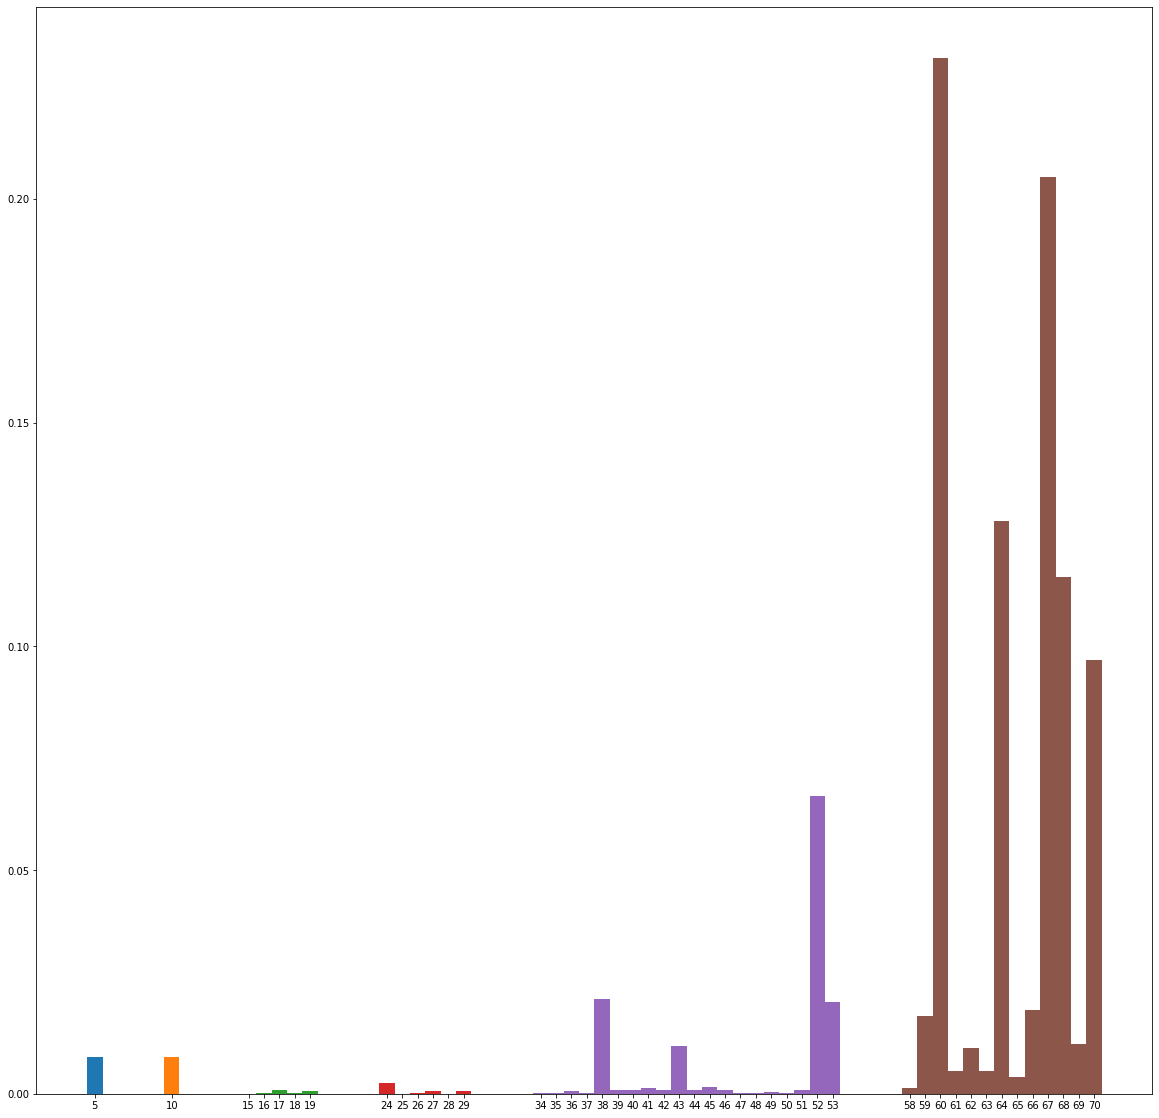

In [39]:
plt.figure(figsize=(20, 20))

width = 1
group_gap = 5

# fig, ax = plt.subplots()

last_index = 0
ind = []
xs = []

for i in range(0, 6):
    group_len = len(ps[i])

    x = np.arange(group_len) + last_index + group_gap
    xs.append(x)

    last_index = x[-1]

    plt.bar(x, ps[i], width)


ind = [x for j in xs for x in j]

x_labels = ['' for _ in range(len(ind))]

former_index = 0
for i, x in enumerate(xs):
    x_labels[former_index + int(len(x) / 2)] = i + 1
    former_index += len(x)

# plt.xticklabels(x_labels, fontsize=14)

#plt.ylabel(r'P_{$/\text{Path}_l$', fontsize=14)
# plt.xticks(ind, [i + 1 for i in range(len(xs))])
plt.xticks(ind)

print(ind)

plt.show()